In [35]:
# Operating System
os_system = "mac"
arch = "arm64"

# File path to your CTest log
file_path = f"./test_logs/Linux-x64-steerable-nafx_20240119_2042.log"

In [36]:
import os
import re
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
font = {'family' : 'sans serif',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

try:
    os.mkdir(os.path.join(os.path.abspath(''), "img"))
except:
    pass 

In [37]:
# Read data from the file
with open(file_path, 'r') as file:
    for line in file:
        if "ONNX" in line:
            # if "cvctes" in line:
            # match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) %\s+(\d+\.\d+|\d+) %\s+", line)
            # print(match.group(1), match.group(2), match.group(3))
            print(line)

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:0/repetition:0			17.0685

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:1/repetition:0			14.9027

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:2/repetition:0			14.5385

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:3/repetition:0			13.5186

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:4/repetition:0			14.7618

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:5/repetition:0			13.3994

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:6/repetition:0			13.7336

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:7/repetition:0			13.2034

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:8/repetition:0			13.1649

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:9/repetition:0			12.9077

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:10/repetition:0			14.4197

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:11/repetition:0			12.8789

ProcessBlockFixture/BM_ONNX_BACKEND/2048/iteration:12/repetition:0			12.59

In [38]:
def getStatisticsFromLog(file_path: str, backend: str) -> list:
    buffer_sizes = []
    mean_values = []
    cv_values = []
    max_values = []
    min_values = []
    percentile_values = []

    with open(file_path, 'r') as file:
        for line in file:
            if backend in line:
                if "mean" in line:
                    match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) ms\s+(\d+\.\d+|\d+) ms\s+", line)
                    buffer_sizes.append(int(match.group(1)))
                    mean_values.append(float(match.group(2)))
                # if "cv" in line:
                #     match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) %\s+(\d+\.\d+|\d+) %\s+", line)
                    cv_values.append(float(match.group(2)))
                if "max" in line:
                    match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) ms\s+(\d+\.\d+|\d+) ms\s+", line)
                    max_values.append(float(match.group(2)))
                if "min" in line:
                    match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) ms\s+(\d+\.\d+|\d+) ms\s+", line)
                    min_values.append(float(match.group(2)))
                if "percentile" in line:
                    match = re.search(r"\/(\d+)\/[a-z0-9:\/_]+\s+(\d+\.\d+|\d+) ms\s+(\d+\.\d+|\d+) ms\s+", line)
                    percentile_values.append(float(match.group(2)))
    
    return [buffer_sizes, mean_values, cv_values, max_values, min_values, percentile_values]

def calculateBufferTime(buffer_sizes: list, sample_rate: float) -> list:
    buffer_time = []
    for i in range(len(buffer_sizes)):
        buffer_time.append(buffer_sizes[i] * 1000 / sample_rate)
    return buffer_time

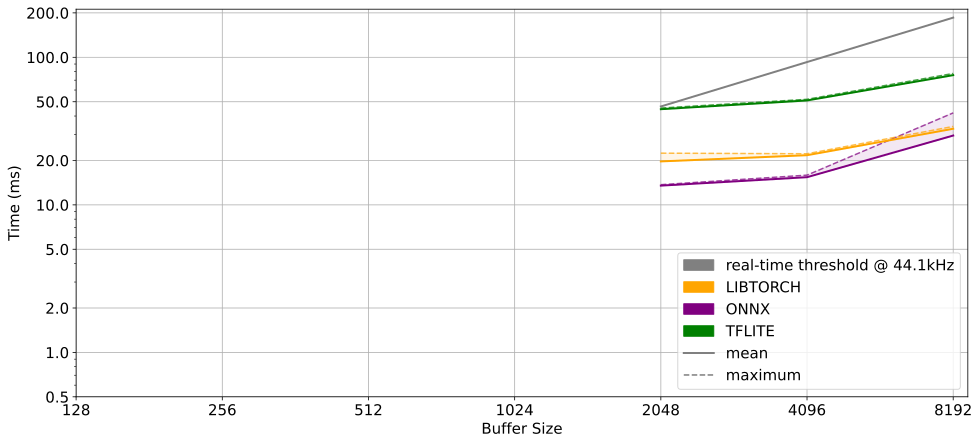

In [39]:
plot_name = "benchmark-" + os_system + "-" + arch + ".svg"

backends = ["ONNX", "TFLITE", "LIBTORCH"]
colors = ["purple", "green", "orange"]
statistics = []
for backend in backends:
    buffer_sizes, mean_values, cv_values, max_values, min_values, percentile_values = getStatisticsFromLog(file_path, backend)
    statistics.append((buffer_sizes, mean_values, cv_values, max_values, min_values, percentile_values))

# Calculate buffer time
buffer_time = calculateBufferTime(statistics[0][0], 44100)

xticks = [128,256,512,1024,2048,4096,8192]
yticks = [0.5,1,2,5,10,20,50,100,200]

# Create plots
fig, ax = plt.subplots(figsize=(16, 7))
for idx, backend in enumerate(zip(backends, colors)):
    ax.plot(statistics[idx][0], statistics[idx][1], color=colors[idx], linewidth=2)
    ax.plot(statistics[idx][0], statistics[idx][3], color=colors[idx], linestyle="--", alpha=0.7)
    ax.fill_between(statistics[idx][0], statistics[idx][1],  statistics[idx][3], color=colors[idx], alpha=0.09)
ax.plot(statistics[0][0], buffer_time, color="grey", linewidth=2)
ax.set_xscale('log')
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel("Buffer Size")
ax.set_yscale('log')
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Time (ms)")
handles, labels = ax.get_legend_handles_labels()
mean_line = Line2D([0], [0], color="grey", label="mean", linewidth=2)
pecentile_line = Line2D([0], [0], color="grey", label="maximum", linestyle="--")
handles.append(mpatches.Patch(color="grey", label="real-time threshold @ 44.1kHz"))
handles.append(mpatches.Patch(color="orange", label="LIBTORCH"))
handles.append(mpatches.Patch(color="purple", label="ONNX"))
handles.append(mpatches.Patch(color="green", label="TFLITE"))
handles.append(mean_line) 
handles.append(pecentile_line)
plt.legend(handles=handles, loc="lower right")
plt.grid(True)
plt.savefig(f"./img/{plot_name}")
plt.show()